In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display
import sys

In [3]:
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../../scripts')
from plot_helpers import nice_name_map, plot_scatter_with_lines, save_plot

In [9]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2021-01-07-report-scaling/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,timeout_seconds,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length
53,2,independent,592857,1,0,zipf,0,12,mpi_no_master_frontier,512,120.0,512,818696,0,4636721,0,1035910
18,0,independent,30000,1,0,zipf,0,0,mpi_no_master_frontier,64,120.0,64,20261,0,1267054,0,50502
21,2,independent,592857,1,0,zipf,0,6,mpi_priority_frontier_simd,64,120.0,64,110400,0,37455829,0,1035910
29,0,independent,30000,1,0,zipf,0,11,mpi_no_master_frontier,64,120.0,64,29756,0,657827,0,50502
80,0,independent,30000,1,0,zipf,0,18,mpi_no_master_frontier_simd,512,120.0,512,63512,0,66307,0,50502


In [15]:
diff_programs = [
    'mpi_no_master_frontier_simd',
    'mpi_priority_frontier_simd',
]

for diff_program in diff_programs:
    assert (benchmark_results['diff_program'] == diff_program).any()

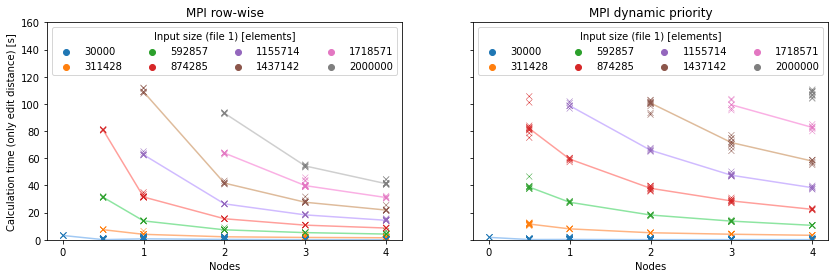

In [397]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(1, len(diff_programs), figsize=(14, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(diff_programs):
    temp = benchmark_results.copy()
    temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
    temp['mpi_nodes'] = temp['mpi_procs'] / 128
    temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_nodes'])['seconds_until_len'].median().unstack('input_length_1')
    
    this_ax = ax[diff_program_i]
    plot_scatter_with_lines(
        ax=this_ax,
        scatter_data=temp,
        line_data=temp_2,
        x_key='mpi_nodes',
        y_key='seconds_until_len',
        hue_key='input_length_1',
        sort_hue_keys=True,
        hue_to_label=str,
    )
    this_ax.set_title(nice_name_map[diff_program])
    this_ax.set_xticks(np.arange(np.ceil(temp['mpi_nodes'].max()) + 1))
    this_ax.set_ylim(0, 160)

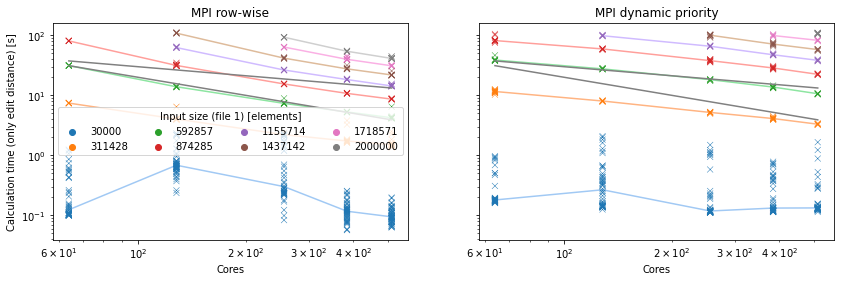

In [257]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(1, len(diff_programs), figsize=(14, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(diff_programs):
    temp = benchmark_results.copy()
    temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
    temp = temp[temp['mpi_procs'] > 1]
    temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_procs'])['seconds_until_len'].median().unstack('input_length_1')
    
    this_ax = ax[diff_program_i]
    plot_scatter_with_lines(
        ax=this_ax,
        scatter_data=temp,
        line_data=temp_2,
        x_key='mpi_procs',
        y_key='seconds_until_len',
        hue_key='input_length_1',
        sort_hue_keys=True,
        hue_to_label=str,
        show_legend=(diff_program_i == 0),
    )
    this_ax.set_title(nice_name_map[diff_program])
    this_ax.set_xscale('log')
    this_ax.set_yscale('log')
    
    this_ax.plot(np.linspace(64, 512), 2e3 / np.linspace(64, 512), color='grey')
    this_ax.plot(np.linspace(64, 512), 0.3e3 / np.linspace(64, 512) ** 0.5, color='grey')

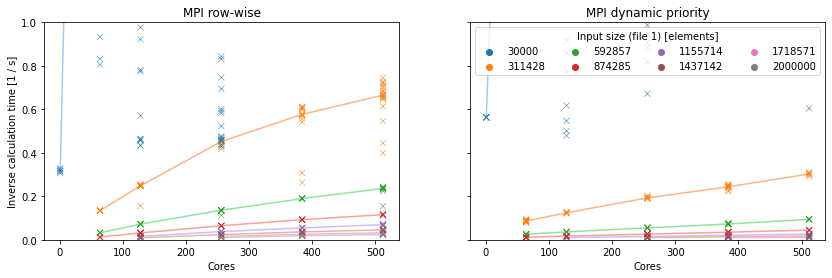

In [241]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(1, len(diff_programs), figsize=(14, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(diff_programs):
    temp = benchmark_results.copy()
    temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
    temp['inv_seconds_until_len'] = 1 / temp['seconds_until_len']
    temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_procs'])['inv_seconds_until_len'].median().unstack('input_length_1')
    
    this_ax = ax[diff_program_i]
    plot_scatter_with_lines(
        ax=this_ax,
        scatter_data=temp,
        line_data=temp_2,
        x_key='mpi_procs',
        y_key='inv_seconds_until_len',
        hue_key='input_length_1',
        sort_hue_keys=True,
        hue_to_label=str,
        show_legend=(diff_program_i == 1),
    )
    this_ax.set_title(nice_name_map[diff_program])
    this_ax.set_ylim(0, 1)

In [369]:
temp = benchmark_results.copy()
temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
temp['cells_per_second'] = temp['input_length_1'] * temp['min_edit_length'] / temp['seconds_until_len']
temp['mpi_nodes'] = temp['mpi_procs'] / 128
temp['cost'] = temp['mpi_procs'] * temp['seconds_until_len'] / (temp['input_length_1'] * temp['min_edit_length'])
ideal_cost = temp.loc[temp['mpi_nodes'] >= 1, 'cost'].min()
ideal_cost

2.8378229861409807e-09

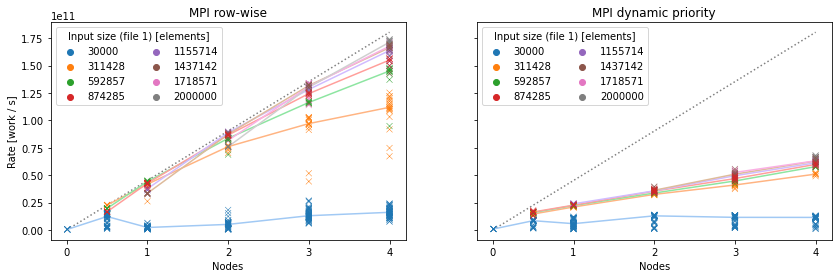

In [388]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(1, len(diff_programs), figsize=(14, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(diff_programs):
    temp = benchmark_results.copy()
    temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
    temp['cells_per_second'] = temp['input_length_1'] * temp['min_edit_length'] / temp['seconds_until_len']
    temp['mpi_nodes'] = temp['mpi_procs'] / 128
    temp['cost'] = temp['mpi_procs'] * temp['seconds_until_len'] / (temp['input_length_1'] * temp['min_edit_length'])
    temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_nodes'])['cells_per_second'].median().unstack('input_length_1')
    
    this_ax = ax[diff_program_i]
    plot_scatter_with_lines(
        ax=this_ax,
        scatter_data=temp,
        line_data=temp_2,
        x_key='mpi_nodes',
        y_key='cells_per_second',
        hue_key='input_length_1',
        sort_hue_keys=True,
        hue_to_label=str,
        legend_columns=2,
    )
    this_ax.set_title(nice_name_map[diff_program])
    this_ax.set_xticks(np.arange(np.ceil(temp['mpi_nodes'].max()) + 1))
    this_ax.plot(
        np.linspace(0, 4),
        np.linspace(0, 4 * 128 / ideal_cost),
        color='grey',
        linestyle='dotted',
        zorder=-1,
    )